## Reference check for number of targets in GameSession table

*import libraries*

In [1]:
import os
import sys
import glob
import sqlite3 as sl

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
import statistics


In [2]:
pd.options.display.max_rows = 100

**import target data from database**

In [3]:
path = './data/P00' 

In [4]:
# loop dfs from *.csv
list_of_dfs = []

list_of_dfs = [pd.read_csv(filename) for filename in glob.glob(path + '*_targets.csv')]

In [5]:
# sample list of df
list_of_dfs[0].head()

,PatientID,CreatedDate,SessionID,Score,Strength,Coordination,Agility,SessionTime,NumberOfTargets
0,TTSH-CHISEL0Pa/Gtc3DUqoPVREp+I/qg==,2022-03-03 02:57:50,TTSH-CHISELuUvzJG4jtU2x7LwcnIDtVA==,321.0,25.078125,42.999474,-1345.362652,10.554035,128
1,TTSH-CHISEL0Pa/Gtc3DUqoPVREp+I/qg==,2022-03-03 03:26:48,TTSH-CHISELATu6AXcc2ECeDZLmfzceLg==,1596.0,49.322033,47.664755,15.144465,19.592974,297
2,TTSH-CHISEL0Pa/Gtc3DUqoPVREp+I/qg==,2022-03-03 09:09:13,TTSH-CHISELfAPnD90VIUqaw/UOUhAk2g==,113.0,40.000000,34.992334,68.233155,1.553366,33
3,TTSH-CHISEL0Pa/Gtc3DUqoPVREp+I/qg==,2022-03-03 09:37:54,TTSH-CHISELPFPihGOPo0a+Me0oGLM1Yw==,181.0,61.428570,35.354460,33.024178,1.496792,33
4,TTSH-CHISEL0Pa/Gtc3DUqoPVREp+I/qg==,2022-03-10 03:17:21,TTSH-CHISELPuYYoWmBD0SZ54Yz+19suA==,161.0,42.500000,36.089092,16.874067,2.595096,38


**import target data from ttsh**

In [6]:
# dfs from ttsh
xls = pd.ExcelFile('data/HMANTele_Data.xlsx')

In [7]:
ttsh_dfs = []
for name in xls.sheet_names:
    df_temp = pd.read_excel(xls, sheet_name=name, header=1)
    ttsh_dfs.append(df_temp)

In [8]:
ttsh_dfs[0].head()

,Day,"Date_session (1,2,3)",#1_Time/mins,#1 Reps/session,Unnamed: 4,#2Time/mins,#2 Reps/session,Unnamed: 7,#3 Time:/mins,#3 Reps/session,Unnamed: 10,#4 Time/min,#4 Reps/session,Unnamed: 13,Total time/day,Total reps/day,Comments,Unnamed: 17,Unnamed: 18
0,1,2022-03-10 00:00:00,2.6,38.0,NaN,0.88,16.0,NaN,42.3,509.0,NaN,5.9,NaN,NaN,51.68,563.0,NaN,NaN,NaT
1,2,2022-03-11 00:00:00,10.5,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.50,105.0,NaN,NaN,NaT
2,3,2022-03-12 00:00:00,10.5,104.0,NaN,20.30,323.0,NaN,30.9,451.0,NaN,NaN,NaN,NaN,61.70,878.0,NaN,NaN,NaT
3,4,2022-03-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,NaT
4,5,2022-03-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,did we call pt after 2 days of 0 activity ?,NaN,NaT


**patient dictionary**

In [9]:
user_id_dict = {
    'TTSH-CHISELRGgLPwL3Lk6JTgBaVP4bjg==':'Test_01',
    'TTSH-CHISEL2gpumVcbJE267TKKceWbOA==':'NULL', 
    'TTSH-CHISEL0Pa/Gtc3DUqoPVREp+I/qg==':'001', 
    'TTSH-CHISEL9GsWU5zb50CfPyoLNy7qvg==':'002',
    'TTSH-CHISELamITRYYb9UymNH+3xzylgg==':'003', 
    'TTSH-CHISEL6IRO4pIMDUCpIRFbGnO26w==':'004',
    'TTSH-CHISELZSJj4EGZh0iiozqhx3Gf4g==':'005',
    'TTSH-CHISELCn5PqGNyMkKoyFYaOryw5g==':'006'
}; 


**cleaning of dfs**

In [10]:
list_of_groupsessions = []
for df in list_of_dfs:
    df.replace({'PatientID':user_id_dict},inplace=True)
    df['date_time'] = pd.to_datetime(df['CreatedDate'], format='%Y-%m-%d %H:%M:%S')
    df['just_date'] = df['date_time'].dt.date
    
    groupsession = df.groupby(['just_date']).sum().reset_index()
    list_of_groupsessions.append(groupsession)

**cleaning of ttsh_dfs**

In [11]:
list_from_ttshsessions = []
for df in ttsh_dfs:
    df.columns = df.columns.str.replace(' ','')
    df.rename(columns={'Date_session(1,2,3)' : 'date',
                        'Totaltime/day' : 'ttsh_time',
                        'Totalreps/day' : 'ttsh_targets'}, inplace=True)
    targets_df = df[df['date'].astype(str).str.contains('2022-')][['date','ttsh_time','ttsh_targets']].fillna(0)
    targets_df['date_time'] = pd.to_datetime(targets_df['date'], format='%Y-%m-%d %H:%M:%S')
    targets_df['just_date'] = targets_df['date_time'].dt.date
    
    list_from_ttshsessions.append(targets_df)

**compare df**

In [12]:
list_of_comparisons = []
for nr in range(0,len(list_from_ttshsessions)):
    df = pd.merge(list_of_groupsessions[nr],list_from_ttshsessions[nr][list_from_ttshsessions[nr]['ttsh_time']!=0], on='just_date', how='outer').drop(columns=['Score','Strength','Coordination','Agility','date','date_time'])
    df = df.fillna(0)
    df['diff_time'] = df['SessionTime'] - df['ttsh_time']
    df['diff_time'] = df['diff_time'].round(2)
    df['diff_targets'] = df['NumberOfTargets'] - df['ttsh_targets']
    
    list_of_comparisons.append(df)
    

### display sessions

#### display sessions from dfs

#### P001

In [13]:
list_of_groupsessions[0]

,just_date,Score,Strength,Coordination,Agility,SessionTime,NumberOfTargets
0,2022-03-03,2211.0,175.828728,161.011024,-1228.960854,33.197168,491
1,2022-03-10,2934.0,173.929615,167.369573,-233.032904,51.714651,654
2,2022-03-11,219.0,20.769230,47.588621,20.684547,10.493445,105
3,2022-03-12,4042.0,175.223047,151.330928,73.707095,61.658001,878
4,2022-03-15,2301.0,158.976776,149.103749,-524.591759,31.536377,467
5,2022-03-17,2476.0,53.779697,49.239704,-814.104143,1346.632446,562
6,2022-03-21,3462.0,150.215042,104.382799,29.691547,51.542343,671
7,2022-03-22,2078.0,70.103806,48.287907,-327.145745,32.187260,409
8,2022-03-23,1949.0,76.688744,48.094645,23.666030,31.400736,402
9,2022-03-24,920.0,352.603004,209.353268,-1823.030661,20.182383,193


In [14]:
list_from_ttshsessions[0]

,date,ttsh_time,ttsh_targets,date_time,just_date
0,2022-03-10,51.68,563.0,2022-03-10,2022-03-10
1,2022-03-11,10.50,105.0,2022-03-11,2022-03-11
2,2022-03-12,61.70,878.0,2022-03-12,2022-03-12
3,2022-03-13,0.00,0.0,2022-03-13,2022-03-13
4,2022-03-14,0.00,0.0,2022-03-14,2022-03-14
5,2022-03-15,31.53,467.0,2022-03-15,2022-03-15
6,2022-03-16,0.00,0.0,2022-03-16,2022-03-16
7,2022-03-17,1346.60,562.0,2022-03-17,2022-03-17
8,2022-03-18,0.00,0.0,2022-03-18,2022-03-18
9,2022-03-19,0.00,0.0,2022-03-19,2022-03-19


In [15]:
list_of_comparisons[0]

,just_date,SessionTime,NumberOfTargets,ttsh_time,ttsh_targets,diff_time,diff_targets
0,2022-03-03,33.197168,491.0,0.00,0.0,33.20,491.0
1,2022-03-10,51.714651,654.0,51.68,563.0,0.03,91.0
2,2022-03-11,10.493445,105.0,10.50,105.0,-0.01,0.0
3,2022-03-12,61.658001,878.0,61.70,878.0,-0.04,0.0
4,2022-03-15,31.536377,467.0,31.53,467.0,0.01,0.0
5,2022-03-17,1346.632446,562.0,1346.60,562.0,0.03,0.0
6,2022-03-21,51.542343,671.0,51.50,671.0,0.04,0.0
7,2022-03-22,32.187260,409.0,32.20,409.0,-0.01,0.0
8,2022-03-23,31.400736,402.0,31.40,402.0,0.00,0.0
9,2022-03-24,20.182383,193.0,20.19,193.0,-0.01,0.0


#### P002

In [16]:
list_of_comparisons[1]

,just_date,SessionTime,NumberOfTargets,ttsh_time,ttsh_targets,diff_time,diff_targets
0,2022-03-17,28.909433,338,0.00,0.0,28.91,338.0
1,2022-03-21,53.376962,733,0.00,0.0,53.38,733.0
2,2022-03-23,1.549585,42,0.00,0.0,1.55,42.0
3,2022-03-24,88.448853,1491,88.40,1491.0,0.05,0.0
4,2022-03-25,41.743582,746,41.72,746.0,0.02,0.0
5,2022-03-26,76.481487,1642,76.50,1642.0,-0.02,0.0
6,2022-03-27,87.613304,1840,87.70,1840.0,-0.09,0.0
7,2022-03-28,81.342403,2000,81.30,2000.0,0.04,0.0
8,2022-03-29,122.482590,3129,122.50,3129.0,-0.02,0.0
9,2022-03-30,81.721363,2063,81.70,2063.0,0.02,0.0


#### P003

In [17]:
list_of_comparisons[2]

,just_date,SessionTime,NumberOfTargets,ttsh_time,ttsh_targets,diff_time,diff_targets
0,2022-03-07,37.157238,543.0,0.0,0.0,37.16,543.0
1,2022-03-09,61.677113,820.0,0.0,0.0,61.68,820.0
2,2022-03-10,0.595276,10.0,0.0,0.0,0.60,10.0
3,2022-03-29,35.775889,528.0,0.0,0.0,35.78,528.0
4,2022-03-30,54.088591,803.0,54.0,803.0,0.09,0.0
5,2022-03-31,87.441004,1289.0,87.4,1289.0,0.04,0.0
6,2022-04-01,88.455952,1443.0,88.4,1443.0,0.06,0.0
7,2022-04-02,116.889919,1921.0,116.9,1921.0,-0.01,0.0
8,2022-04-03,101.776596,1799.0,101.8,1799.0,-0.02,0.0
9,2022-04-04,44.911617,772.0,44.9,772.0,0.01,0.0


#### P004

In [18]:
list_of_comparisons[3]

,just_date,SessionTime,NumberOfTargets,ttsh_time,ttsh_targets,diff_time,diff_targets
0,2022-04-13,17.033276,150,0.00,0.0,17.03,150.0
1,2022-04-19,74.419014,923,0.00,0.0,74.42,923.0
2,2022-04-22,44.747900,460,44.76,460.0,-0.01,0.0
3,2022-04-23,65.176076,808,65.22,808.0,-0.04,0.0
4,2022-04-24,91.306280,1809,91.30,1809.0,0.01,0.0
5,2022-04-25,149.688128,2180,149.61,2180.0,0.08,0.0
6,2022-04-26,121.186707,1812,121.20,1812.0,-0.01,0.0
7,2022-04-27,136.221924,2258,136.20,2258.0,0.02,0.0
8,2022-04-28,134.531422,2266,134.50,2266.0,0.03,0.0
9,2022-04-29,112.935331,2036,112.90,2036.0,0.04,0.0


#### P005

In [19]:
list_of_comparisons[4]

,just_date,SessionTime,NumberOfTargets,ttsh_time,ttsh_targets,diff_time,diff_targets
0,2022-05-13,24.172035,493,0.00,0.0,24.17,493.0
1,2022-05-17,69.837855,1098,58.10,1022.0,11.74,76.0
2,2022-05-18,123.658097,2669,123.20,2666.0,0.46,3.0
3,2022-05-19,125.575493,2601,125.60,2601.0,-0.02,0.0
4,2022-05-20,90.883499,1919,90.90,1919.0,-0.02,0.0
5,2022-05-21,109.155767,2554,94.10,2148.0,15.06,406.0
6,2022-05-22,150.262012,3529,107.80,2653.0,42.46,876.0
7,2022-05-23,31.125179,709,88.70,1991.0,-57.57,-1282.0
8,2022-05-24,94.842075,2280,94.80,2280.0,0.04,0.0
9,2022-05-25,97.842368,2309,97.90,2309.0,-0.06,0.0


#### P006

In [20]:
list_of_comparisons[5]

,just_date,SessionTime,NumberOfTargets,ttsh_time,ttsh_targets,diff_time,diff_targets
0,2022-05-13,15.488509,465,15.2,922.0,0.29,-457.0
1,2022-05-14,74.442083,1797,74.4,1797.0,0.04,0.0
2,2022-05-15,93.724401,2084,93.8,2084.0,-0.08,0.0
3,2022-05-16,89.654608,2130,89.7,2130.0,-0.05,0.0
4,2022-05-17,87.888329,2242,87.9,2242.0,-0.01,0.0
5,2022-05-18,81.420086,2100,81.4,2100.0,0.02,0.0
6,2022-05-19,91.005131,2307,91.0,2307.0,0.01,0.0
7,2022-05-20,72.024746,1678,72.0,1678.0,0.02,0.0
8,2022-05-21,79.413845,2141,79.4,2141.0,0.01,0.0
9,2022-05-23,94.468332,2519,94.5,2519.0,-0.03,0.0


### Plot sessions

#### Number of targets

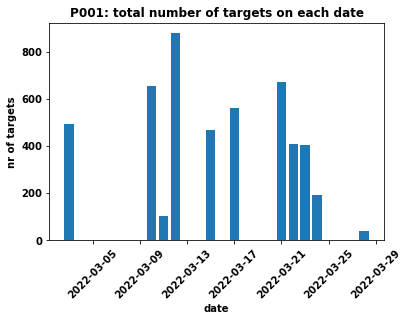

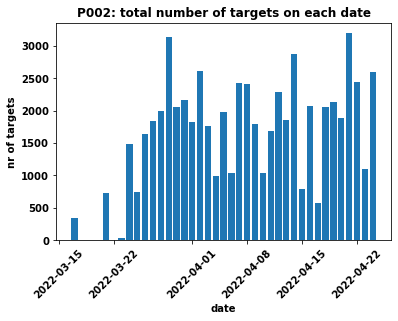

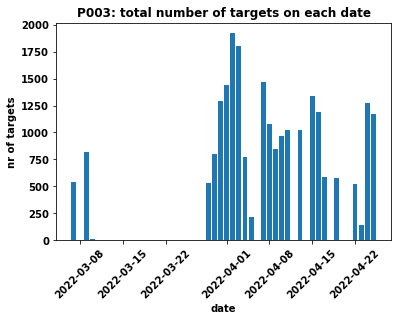

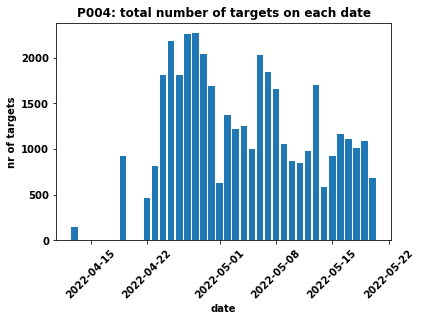

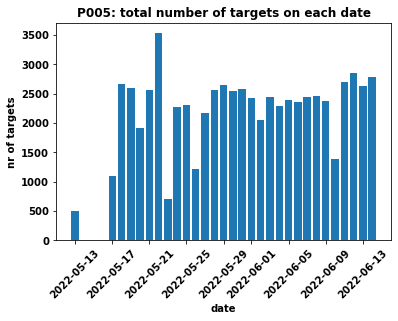

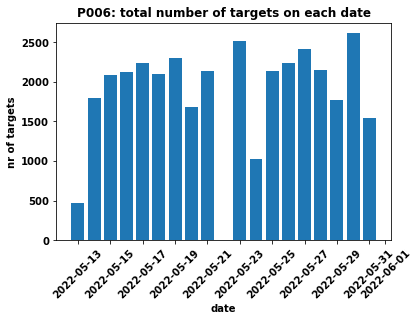

In [21]:
# plot number of targets by date
for nr, session in enumerate(list_of_groupsessions):
    PatientID = list_of_dfs[nr]['PatientID'].unique()[0]
    plt.bar(session['just_date'],session['NumberOfTargets']);
    plt.xlabel('date')
    plt.xticks(rotation=45)
    # plt.yticks(range(0,20))
    plt.ylabel('nr of targets');
    # plt.ylim(top=1000)
    plt.title(f'P{PatientID}: total number of targets on each date');
    plt.show();

#### Time spend 

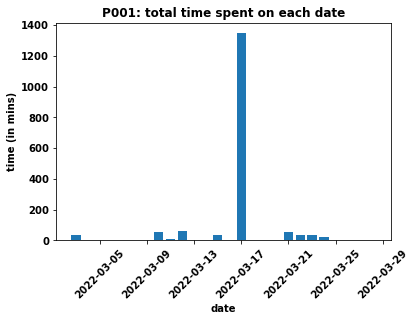

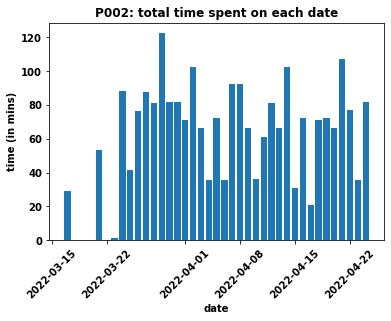

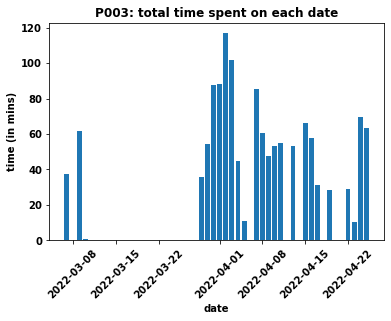

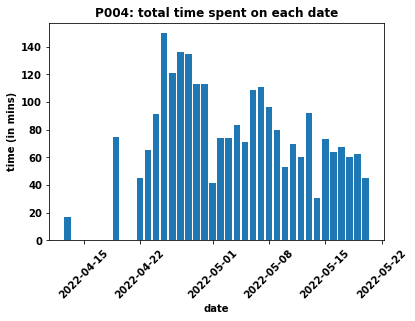

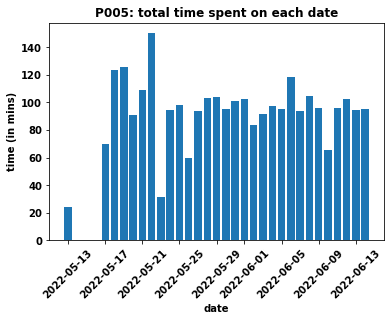

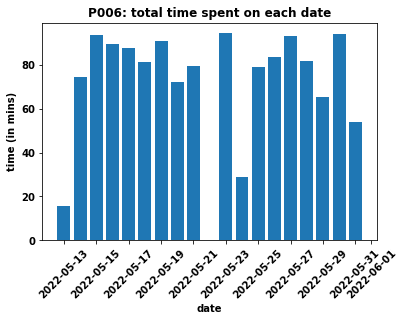

In [22]:
# plot time spent by date
for nr, session in enumerate(list_of_groupsessions):
    PatientID = list_of_dfs[nr]['PatientID'].unique()[0]
    plt.bar(session['just_date'],session['SessionTime']);
    plt.xlabel('date')
    plt.xticks(rotation=45)
    # plt.yticks(range(0,20))
    plt.ylabel('time (in mins)');
    # plt.ylim(top=1000)
    plt.title(f'P{PatientID}: total time spent on each date');
    plt.show();